In [25]:
import pandas as pd
import numpy as np
import math
import haversine as hs
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
from sklearn.cluster import KMeans
from haversine import Unit

In [26]:
demand_seasonality_data = pd.read_csv('demand_seasonalities.csv')
metro_areas_data = pd.read_csv('msa.csv')
demand_pmf_by_zip_data = pd.read_csv('zip3_pmf.csv')
price_to_ship_in_zip_data = pd.read_csv('order_shipment_matrix.csv')
zip_coordinates_data = pd.read_csv('zip3_coordinates.csv')

In [27]:
price_to_ship_in_zip_data['minimum_distance'] = np.array([0,50,150,300,600,1000,1400,1800])
price_to_ship_in_zip_data['maximum_distance'] = np.array([50, 150,300,600,1000,1400,1800, 50000])
price_to_ship_in_zip_data['Zone'] = [z[0] for z in price_to_ship_in_zip_data['Zone'].astype('str')]
price_to_ship_in_zip_data

,Zone,Cost ($) per product unit,minimum_distance,maximum_distance
0,1,13.29,0,50
1,2,15.09,50,150
2,3,19.05,150,300
3,4,24.15,300,600
4,5,28.73,600,1000
5,6,34.00,1000,1400
6,7,36.17,1400,1800
7,8,38.81,1800,50000


In [28]:
price_to_ship_in_zip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Zone                       8 non-null      object 
 1   Cost ($) per product unit  8 non-null      float64
 2   minimum_distance           8 non-null      int32  
 3   maximum_distance           8 non-null      int32  
dtypes: float64(1), int32(2), object(1)
memory usage: 324.0+ bytes


In [29]:
df_coords_to_geo = gpd.GeoDataFrame(zip_coordinates_data, geometry= gpd.points_from_xy(zip_coordinates_data.Lon, zip_coordinates_data.Lat))
df_coords_to_geo

,ZIP3,Lat,Lon,geometry
0,10,42.221598,-72.573558,POINT (-72.57356 42.22160)
1,11,42.105773,-72.583739,POINT (-72.58374 42.10577)
2,12,42.396595,-73.237576,POINT (-73.23758 42.39659)
3,13,42.578956,-72.540044,POINT (-72.54004 42.57896)
4,14,42.566233,-71.696724,POINT (-71.69672 42.56623)
...,...,...,...,...
887,995,60.970213,-151.140110,POINT (-151.14011 60.97021)
888,996,60.524385,-153.405946,POINT (-153.40595 60.52438)
889,997,65.359648,-151.894015,POINT (-151.89402 65.35965)
890,998,58.188334,-135.227811,POINT (-135.22781 58.18833)


Next, we get the map of the USA

In [30]:
world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

C:\Users\Atharva Ketkar\AppData\Local\Temp\ipykernel_41952\3432786234.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

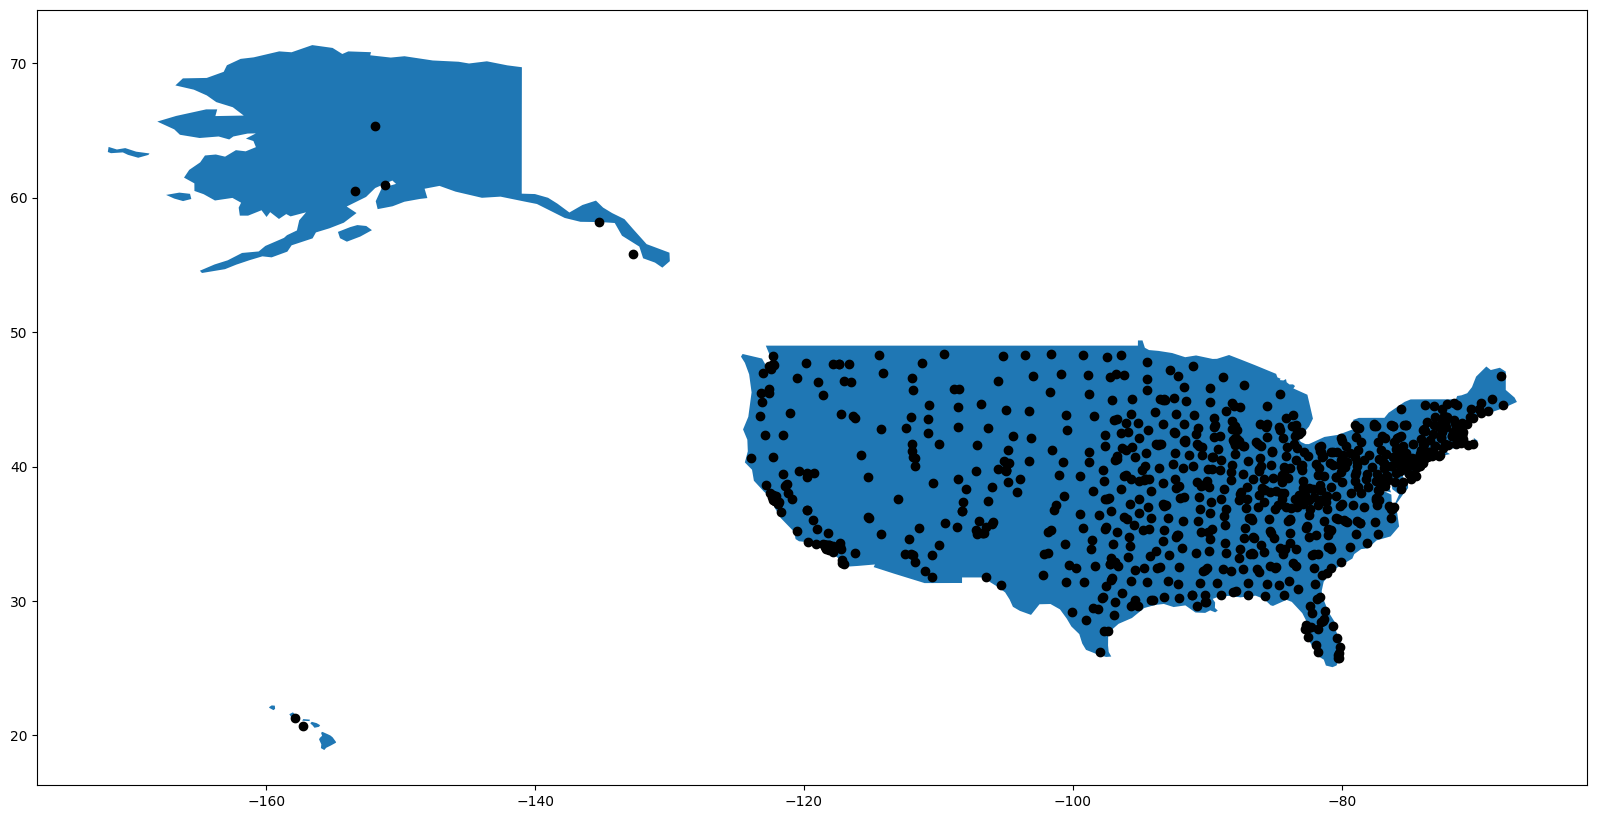

In [31]:
axis = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))
df_coords_to_geo.plot(ax=axis, color = 'black')

# Task 1

There are 4 FCs: NY, Atlanta, Salt Lake City, and El Paso. So we have to cluster the points around these 4 as the cluster centroids.

In [70]:
clusters = zip_coordinates_data.loc[zip_coordinates_data['ZIP3'].isin([134, 303, 799, 841])]
clusters = clusters.loc[:,['Lat', 'Lon']]

coordinate_data = zip_coordinates_data.loc[:, ['Lat', 'Lon']]


id2fc = {id:zip for id,zip in enumerate([134, 303, 799, 841])}


def cluster_points(centroids, data):
    clusters = np.array(centroids)
    coordinate_data = np.array(data)
    new_data = pd.DataFrame(coordinate_data, columns=['Lat', 'Lon'])
    sorted_points = []
    distances = []
    for x in coordinate_data:
        dists = []
        for centroid in clusters:
            dists.append(hs.haversine(centroid, x, unit= Unit.MILES))
        centroid_idx = np.argmin(dists)

        sorted_points.append(id2fc[centroid_idx])
        distances.append(dists[centroid_idx])
    
    new_data['centroid'] = sorted_points
    new_data['Distance'] = distances

    return new_data

clustered = cluster_points(clusters, coordinate_data)

In [33]:
clustered

,Lat,Lon,centroid,Distance
0,42.221598,-72.573558,134,152.844754
1,42.105773,-72.583739,134,155.861249
2,42.396595,-73.237576,134,116.977838
3,42.578956,-72.540044,134,146.032424
4,42.566233,-71.696724,134,187.899459
...,...,...,...,...
887,60.970213,-151.140110,841,2155.791513
888,60.524385,-153.405946,841,2216.540926
889,65.359648,-151.894015,841,2305.416818
890,58.188334,-135.227811,841,1581.003726


In [34]:
clustered['centroid'].value_counts()

centroid
303    328
134    285
841    191
799     88
Name: count, dtype: int64

Thus we have allotted each location to its closest FC. Atlanta will serve 328 locations, New York will serve 285, Utah 191, and Texas 88.

In [35]:
df_geo = pd.merge(df_coords_to_geo, clustered, how= 'left', on= ['Lat', 'Lon'])
df_FCs = df_geo[df_geo['ZIP3'].isin([134, 303, 799, 841])]
df_locations = df_geo[~df_geo['ZIP3'].isin([134,303,799,841])]

<Axes: >

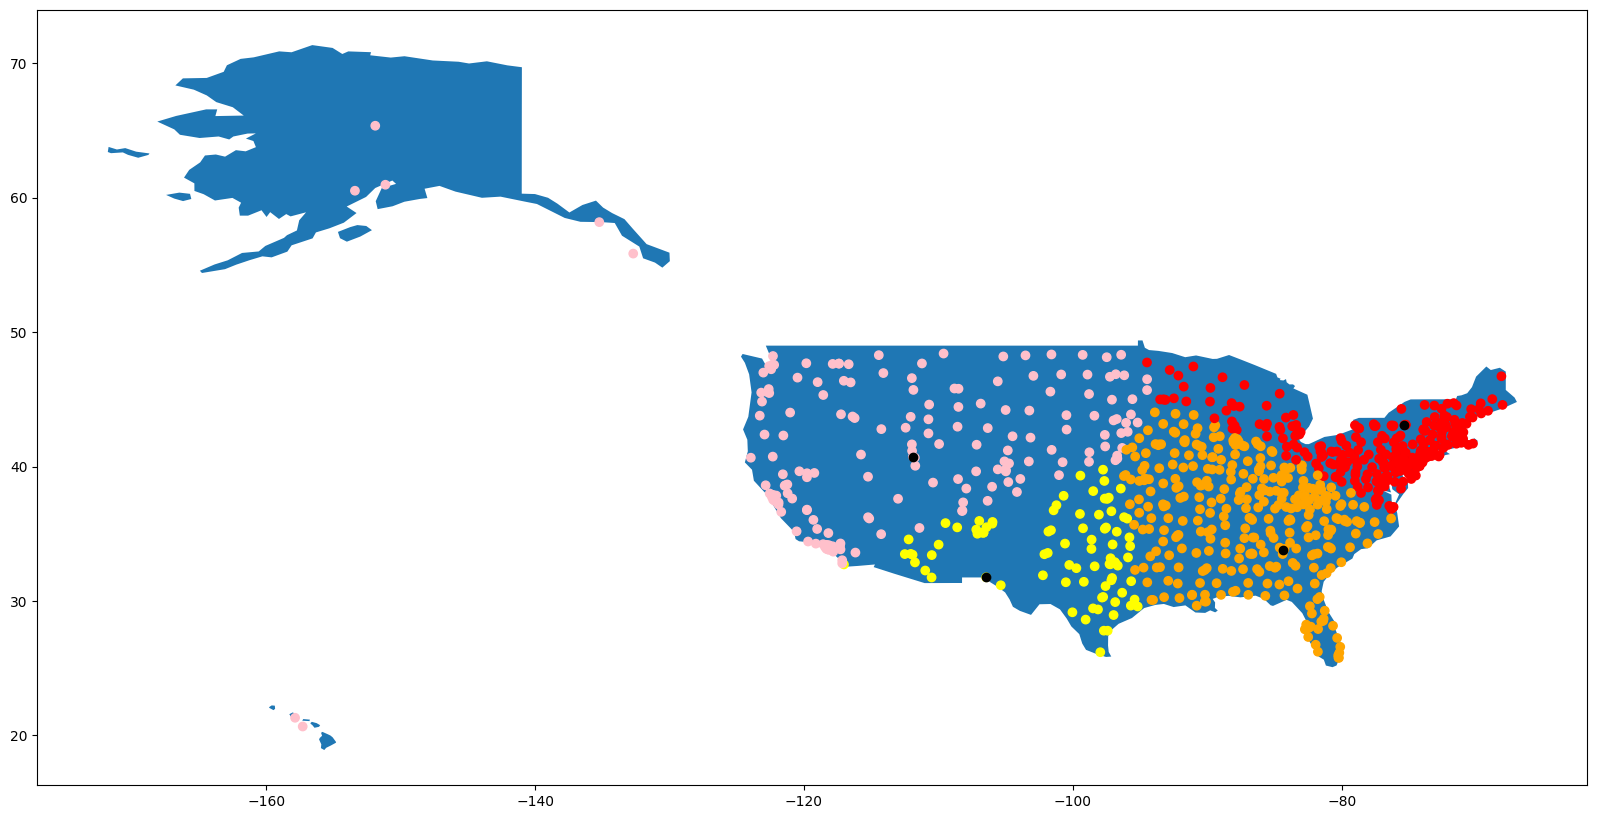

In [36]:
axis2 = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))
colors = {134:'red', 303: 'orange', 799:'yellow', 841: 'pink'}
df_geo.plot(ax = axis2, c= [colors[center] for center in df_geo['centroid']])
df_FCs.plot(ax= axis2, color = 'black')

In [37]:
def get_cost(distance):
    cost = 0.0
    for j in range(len(price_to_ship_in_zip_data)):
        if distance > price_to_ship_in_zip_data.loc[j, 'minimum_distance'] and distance <= price_to_ship_in_zip_data.loc[j, 'maximum_distance']:
            cost = price_to_ship_in_zip_data.loc[j, 'Cost ($) per product unit']
            break
    return cost

def get_zone(distance):
    zone = 0
    for j in range(len(price_to_ship_in_zip_data)):
        if distance > price_to_ship_in_zip_data.loc[j, 'minimum_distance'] and distance <= price_to_ship_in_zip_data.loc[j, 'maximum_distance']:
            zone = price_to_ship_in_zip_data.loc[j, 'Zone']
            break
    return zone

df_locations['Cost'] = df_locations['Distance'].apply(get_cost)
df_locations['Zone'] = df_locations['Distance'].apply(get_zone)


c:\miniconda\envs\warehousing\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\miniconda\envs\warehousing\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [38]:
def get_lead_times(distance):
    lead_time = 0
    if distance <= 500:
        lead_time = 1
    elif distance <= 1000:
        lead_time = 2
    else:
        lead_time = 3
    return lead_time

df_locations['Lead_Time'] = df_locations['Distance'].apply(get_lead_times)

c:\miniconda\envs\warehousing\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [39]:
print('Minimum cost = ', np.min(df_locations['Cost']))
print('Mean Cost = ', np.mean(df_locations['Cost']))
print('Maximum Cost = ', np.max(df_locations['Cost']))

Minimum cost =  13.29
Mean Cost =  22.905213483146067
Maximum Cost =  38.81


Initially, SmartHelpBot assumed that all locations will be served within 3 days from the fulfillment centers. However, that is not the case.

In [40]:
df_lost_sales = df_locations[df_locations['Distance'] > 1500]
df_lost_sales

,ZIP3,Lat,Lon,geometry,centroid,Distance,Cost,Zone,Lead_Time
863,967,20.666774,-157.292398,POINT (-157.29240 20.66677),841,2989.974368,38.81,8,3
864,968,21.316271,-157.858771,POINT (-157.85877 21.31627),841,2991.393298,38.81,8,3
889,995,60.970213,-151.140110,POINT (-151.14011 60.97021),841,2155.791513,38.81,8,3
890,996,60.524385,-153.405946,POINT (-153.40595 60.52438),841,2216.540926,38.81,8,3
891,997,65.359648,-151.894015,POINT (-151.89402 65.35965),841,2305.416818,38.81,8,3
892,998,58.188334,-135.227811,POINT (-135.22781 58.18833),841,1581.003726,36.17,7,3


There are 6 lost sales. Lets see which ones.

<Axes: >

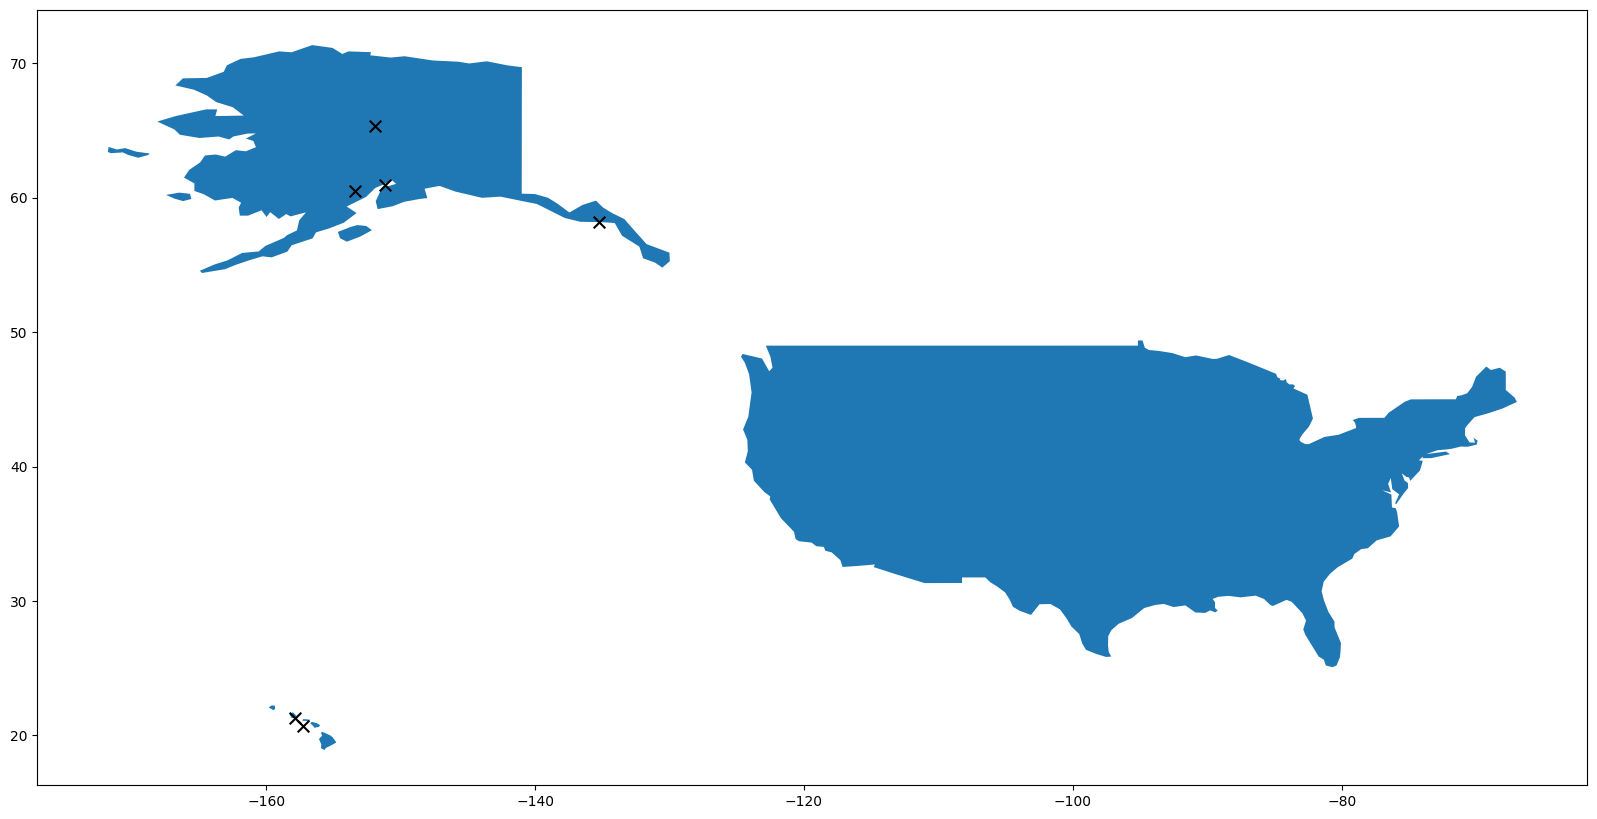

In [41]:
axis3 = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))
df_lost_sales.plot(ax=axis3, marker='x', color = 'black', markersize = 70)

In [42]:
# df_geo.explore()
df_locations[df_locations['Distance'] >=1000]

,ZIP3,Lat,Lon,geometry,centroid,Distance,Cost,Zone,Lead_Time
863,967,20.666774,-157.292398,POINT (-157.29240 20.66677),841,2989.974368,38.81,8,3
864,968,21.316271,-157.858771,POINT (-157.85877 21.31627),841,2991.393298,38.81,8,3
889,995,60.970213,-151.140110,POINT (-151.14011 60.97021),841,2155.791513,38.81,8,3
890,996,60.524385,-153.405946,POINT (-153.40595 60.52438),841,2216.540926,38.81,8,3
891,997,65.359648,-151.894015,POINT (-151.89402 65.35965),841,2305.416818,38.81,8,3
892,998,58.188334,-135.227811,POINT (-135.22781 58.18833),841,1581.003726,36.17,7,3
893,999,55.847715,-132.703055,POINT (-132.70306 55.84772),841,1405.016003,36.17,7,3


In [43]:
from shapely.geometry import LineString
df_lines = pd.merge(df_FCs, df_locations, how='cross')
df_lines = df_lines[df_lines['centroid_y'] == df_lines['ZIP3_x']]
df_lines = df_lines[['ZIP3_x', 'geometry_x', 'ZIP3_y', 'geometry_y',  'Cost', 'Lead_Time']]
df_lines['Lines'] = df_lines.apply(lambda x: LineString([x['geometry_x'], x['geometry_y']]), axis=1)

<Axes: >

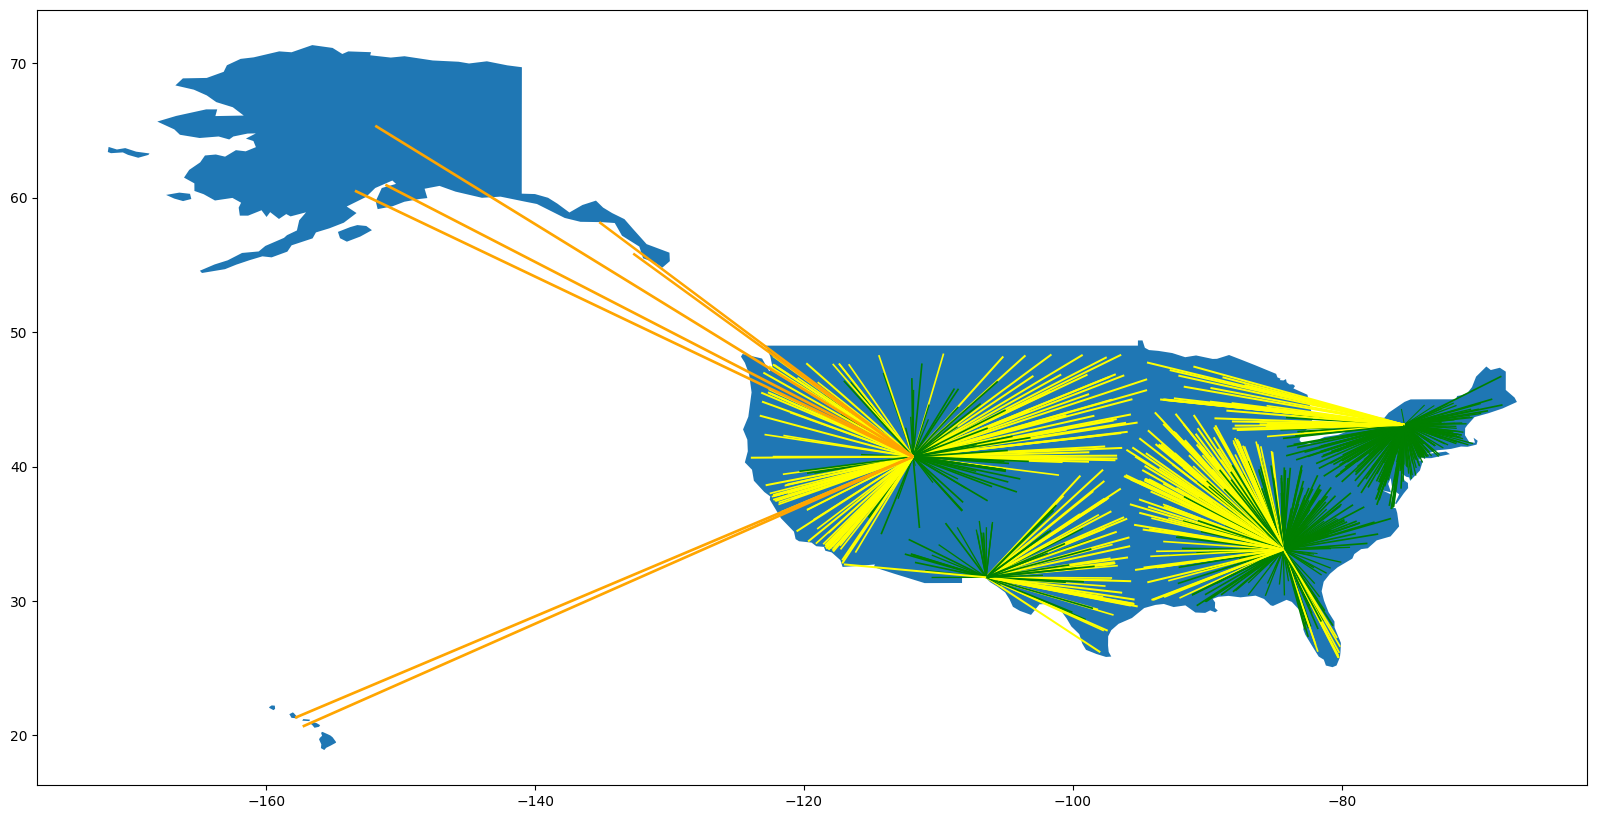

In [44]:
df_lines = df_lines.set_geometry('Lines')
axis4 = world_data[world_data.iso_a3 == 'USA'].plot(figsize = (20,20))

colors = {1:'green', 2:'yellow', 3:'orange'}
widths = {cost:cost/20 for cost in df_lines['Cost']}

df_lines.plot(ax= axis4, color = [colors[time] for time in df_lines['Lead_Time']], linewidth = [widths[cost] for cost in df_lines['Cost']])

# Task 3

The growth in USA is projected to be median = 7.5%, min = 4% and max = 12% YoY

The overall market share is predicted to grow from current 1.8% by min 15%, median 20% and median 25% YoY 

Thus, after 1 year 

min market share = 1.04* 1.8* 1.15

Assume yearly growth of market share is linear i.e uniformly rises daily, we divide yearly ny 12 to get monthly and by 365 to get daily.

In [45]:
worst_case_yearly_growth = 1.8*1.15*1.04*0.01
best_case_yearly_growth = 1.8*1.25*1.12*0.01
median_case_yearly_growth = 1.8*1.20*1.075*0.01

worst_case_monthly_growth = worst_case_yearly_growth*(1/12)
best_case_monthly_growth = best_case_yearly_growth*(1/12)
median_case_monthly_growth = median_case_yearly_growth*(1/12)
median_case_daily_growth = median_case_yearly_growth*(1/365)



USA_territory_table = pd.DataFrame(columns=['Dollars', 'Units', 'Volume', 'Weight'], index=['Yearly', 'Monthly', 'Daily'])
USA_territory_table['Units'] = np.round(np.array([median_case_yearly_growth, median_case_monthly_growth, median_case_daily_growth])*2000000)
USA_territory_table['Dollars'] = np.ceil(USA_territory_table['Units']*300)
USA_territory_table['Volume'] = np.ceil(USA_territory_table['Units']*1.5*2*2)
USA_territory_table['Weight'] = np.round(USA_territory_table['Units']*60)
USA_territory_table


,Dollars,Units,Volume,Weight
Yearly,13932000.0,46440.0,278640.0,2786400.0
Monthly,1161000.0,3870.0,23220.0,232200.0
Daily,38100.0,127.0,762.0,7620.0


In [46]:
current_total_market = 2000000*1.8*0.01

In [47]:
year = np.array([0,1,2,3,4,5])
min_market_share = np.power(1.04, year)* np.power(1.15, year)*1.8*current_total_market
median_market_share = np.power(1.075, year)* np.power(1.20, year)*1.8*current_total_market
max_market_share = np.power(1.12, year)* np.power(1.25, year)*1.8*current_total_market
market_share_dict = {'Year': year, 'Worst_Market_Share': np.round(min_market_share, 0), 
                    'Median_Market_Share': np.round(median_market_share,0), 
                    'Best_Market_Share': np.round(max_market_share,0)}
market_share_df = pd.DataFrame(market_share_dict)
market_share_df

,Year,Worst_Market_Share,Median_Market_Share,Best_Market_Share
0,0,64800.0,64800.0,64800.0
1,1,77501.0,83592.0,90720.0
2,2,92691.0,107834.0,127008.0
3,3,110858.0,139105.0,177811.0
4,4,132587.0,179446.0,248936.0
5,5,158574.0,231485.0,348510.0


## Task 3(b)

Thus we take the projected market share and find the appropriate share at each ZIP using the pmf given

In [88]:
# demand_pmf_by_zip_data['min_market_share'] = demand_pmf_by_zip_data['PMF']*market_share_df.loc[0, 'Min_Market_Share']
demand_pmf_by_zip_data['median_market_share_units'] = demand_pmf_by_zip_data['PMF']*market_share_df.loc[0, 'Median_Market_Share']
# demand_pmf_by_zip_data['max_market_share'] = demand_pmf_by_zip_data['PMF']*market_share_df.loc[0, 'Max_Market_Share']

demand_data = pd.merge(demand_pmf_by_zip_data, df_geo, how='left', on='ZIP3')
demand_data.drop(['geometry', 'Distance'], axis = 1, inplace=True)
demand_data

,ZIP3,PMF,median_market_share,median_market_share_units,Lat,Lon,centroid
0,10,0.002022,131.009270,131.009270,42.221598,-72.573558,134
1,11,0.001160,75.140525,75.140525,42.105773,-72.583739,134
2,12,0.000565,36.596966,36.596966,42.396595,-73.237576,134
3,13,0.000148,9.603425,9.603425,42.578956,-72.540044,134
4,14,0.000743,48.147048,48.147048,42.566233,-71.696724,134
...,...,...,...,...,...,...,...
849,989,0.001130,73.193868,73.193868,46.620679,-120.482577,841
850,990,0.000327,21.218436,21.218436,47.667250,-117.399207,841
851,992,0.001040,67.418827,67.418827,47.661571,-117.396431,841
852,993,0.000951,61.643786,61.643786,46.284993,-118.983570,841


In [89]:
df_metros = df_geo[df_geo['ZIP3'].isin(metro_areas_data['3-digit ZIP code'].values)]
df_metros.drop(['geometry', 'Distance', 'centroid'], axis = 1, inplace=True)

C:\Users\Atharva Ketkar\AppData\Local\Temp\ipykernel_41952\153567601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metros.drop(['geometry', 'Distance', 'centroid'], axis = 1, inplace=True)


In [95]:
def get_market_types(msa, data):
    new_df = data.copy()
    markets_list = []

    points = np.array(data[['Lat', 'Lon']])
    msa_points = np.array(msa[['Lat', 'Lon']])

    for point in points:
        distances = []
        for msa_point in msa_points:
            distances.append(hs.haversine(point, msa_point, unit= Unit.MILES))
        #check if any of the distances is in the range
        if any(distances) <= 100:
            markets_list.append('Primary')

        elif any(distances) <= 400:
            markets_list.append('Secondary')

        else:
            markets_list.append('Tertiary')

    new_df['Market_Type'] = markets_list
    return new_df

df_points_with_market_types = get_market_types(df_metros, demand_data)

In [101]:
df_points = pd.merge(df_points_with_market_types, df_lines, how='left', left_on='ZIP3', right_on='ZIP3_y')
df_points.drop(['geometry_y', 'Lines', 'ZIP3_x', 'Cost', 'median_market_share', 'geometry_x', 'ZIP3_y'], axis = 1, inplace=True)
# df_points.rename(columns={'centroid_x': 'FC_ZIP', 'Lat_x': 'Lat', 'Lon_x': 'Lon'}, inplace=True)
df_points

,ZIP3,PMF,median_market_share_units,Lat,Lon,centroid,Market_Type,Lead_Time
0,10,0.002022,131.009270,42.221598,-72.573558,134,Primary,1.0
1,11,0.001160,75.140525,42.105773,-72.583739,134,Primary,1.0
2,12,0.000565,36.596966,42.396595,-73.237576,134,Primary,1.0
3,13,0.000148,9.603425,42.578956,-72.540044,134,Primary,1.0
4,14,0.000743,48.147048,42.566233,-71.696724,134,Primary,1.0
...,...,...,...,...,...,...,...,...
853,989,0.001130,73.193868,46.620679,-120.482577,841,Primary,2.0
854,990,0.000327,21.218436,47.667250,-117.399207,841,Primary,2.0
855,992,0.001040,67.418827,47.661571,-117.396431,841,Primary,2.0
856,993,0.000951,61.643786,46.284993,-118.983570,841,Primary,2.0


In [104]:
for i in range(len(df_points)):
    if df_points.loc[i, 'Lead_Time'] == 2.0:
        df_points.loc[i, 'median_market_share_units'] *= 0.9
    elif df_points.loc[i, 'Lead_Time'] == 3.0:
        df_points.loc[i, 'median_market_share_units'] *= 0.75
    else:
        df_points.loc[i, 'median_market_share_units'] *= 1.0

In [122]:
import pandas as pd

# Create a DataFrame with a MultiIndex
data = {'A': [1, 2, 3, 4], 'B': [5, 6, 7, 8], 'C': [9, 10, 11, 12]}
arrays = [['bar', 'bar', 'baz', 'baz'], ['one', 'two', 'one', 'two']]
index = pd.MultiIndex.from_arrays(arrays, names=('first', 'second'))
df = pd.DataFrame(data, index=index)
df

A  B   C
first second          
bar   one     1  5   9
      two     2  6  10
baz   one     3  7  11
      two     4  8  12

In [120]:
df_targeted_regions = df_points.groupby('centroid')['median_market_share_units'].sum()
df_regions = pd.DataFrame({'centroid' : [134, 303, 799, 841], 'median_market_share_units': np.round(df_targeted_regions.values)})
df_regions['median_monthly_units'] = np.round(df_regions['median_market_share_units']/12)
df_regions['median_daily_units'] = np.round(df_regions['median_market_share_units']/365)



,centroid,median_market_share_units,median_monthly_units,median_daily_units
0,134,21243.0,1770.0,58.0
1,303,19910.0,1659.0,55.0
2,799,6895.0,575.0,19.0
3,841,14806.0,1234.0,41.0


In [128]:
# Create a sample DataFrame
import pandas as pd
data = {'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]}
df = pd.DataFrame(data)

# Unwrap the rows into a single column
df_stacked = df.stack().reset_index(drop=True)
df_stacked

0    1
1    4
2    7
3    2
4    5
5    8
6    3
7    6
8    9
dtype: int64

In [141]:
arrays = [[134, 134, 134, 303, 303, 303, 799, 799, 799, 841, 841, 841], ['Yearly', 'Monthly','Daily']*4]
index = pd.MultiIndex.from_arrays(arrays, names=('FC', 'Time'))
df_target_regions = pd.DataFrame(columns=['Units', 'Dollars', 'Weight', 'Volume'], index=index)
df_target_regions

units = list(df_regions.drop(['centroid'], axis =1).stack().reset_index(drop=True))
df_target_regions['Units'] = units
df_target_regions['Dollars'] = np.ceil(df_target_regions['Units']*300)
df_target_regions['Weight'] = np.round(df_target_regions['Units']*60)
df_target_regions['Volume'] = np.round(df_target_regions['Units']*1.5*2*2)

In [142]:
df_target_regions

Units    Dollars     Weight    Volume
FC  Time                                            
134 Yearly   21243.0  6372900.0  1274580.0  127458.0
    Monthly   1770.0   531000.0   106200.0   10620.0
    Daily       58.0    17400.0     3480.0     348.0
303 Yearly   19910.0  5973000.0  1194600.0  119460.0
    Monthly   1659.0   497700.0    99540.0    9954.0
    Daily       55.0    16500.0     3300.0     330.0
799 Yearly    6895.0  2068500.0   413700.0   41370.0
    Monthly    575.0   172500.0    34500.0    3450.0
    Daily       19.0     5700.0     1140.0     114.0
841 Yearly   14806.0  4441800.0   888360.0   88836.0
    Monthly   1234.0   370200.0    74040.0    7404.0
    Daily       41.0    12300.0     2460.0     246.0

In [56]:
df_Atlanta = demand_data[demand_data['centroid'] == 303]
df_NY = demand_data[demand_data['centroid'] == 134]
df_Texas = demand_data[demand_data['centroid'] == 799]
df_Utah = demand_data[demand_data['centroid'] == 841]

In [ ]:
get_percent_demand_share